In [29]:
!pip install --quiet dm-haiku

In [30]:
import dataclasses

import jax
from jax import numpy as jnp
import haiku as hk
import tensorflow_datasets as tfds
import tensorflow as tf

In [31]:
(ds_train, _), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

loader = tfds.as_numpy(ds_train)

In [32]:
@dataclasses.dataclass
class Encoder(hk.Module):
  bottleneck: int

  def __call__(self, x):
    x = hk.Conv2D(32, kernel_shape=3, stride=2, padding=(1, 1))(x)
    x = jax.nn.relu(x)
    x = hk.Conv2D(64, kernel_shape=3, stride=2, padding=(1, 1))(x)
    x = jax.nn.relu(x)

    x = x.reshape(-1)

    mu_logsigma = hk.Linear(2 * self.bottleneck)(x)
    mu, logsigma = jnp.split(mu_logsigma, indices_or_sections=2)

    return mu, logsigma


class Decoder(hk.Module):
  def __call__(self, x):
    x = hk.Linear(64)(x)
    x = jax.nn.relu(x)

    x = x.reshape(1, 1, 64)

    x = hk.Conv2DTranspose(64, kernel_shape=5, stride=2, padding="VALID")(x)
    x = jax.nn.relu(x)
    x = hk.Conv2DTranspose(32, kernel_shape=5, stride=2, padding="VALID")(x)
    x = jax.nn.relu(x)    
    x = hk.Conv2DTranspose(1, kernel_shape=4, stride=2, padding="VALID")(x)
    x = jax.nn.sigmoid(x)

    return x


class Sampler(hk.Module):
  def __call__(self, mu, logsigma):
    rng = hk.next_rng_key()
    eps = jax.random.normal(rng, (mu.shape[-1],))
    z = mu + eps * jnp.exp(logsigma)
    return z


@dataclasses.dataclass
class VAE(hk.Module):
  bottleneck: int

  def __call__(self, x):
    mu, logsigma = Encoder(self.bottleneck)(x)
    z = Sampler()(mu, logsigma)
    xhat = Decoder()(z)
    return xhat, mu, logsigma


def _vae(x, bottleneck=2):
  return VAE(bottleneck)(x)


vae = hk.transform(_vae)
key = jax.random.PRNGKey(1)

params = vae.init(key, jnp.ones((28, 28, 1)))

In [33]:
key, subkey = jax.random.split(key)

xhat, mu, logsigma = vae.apply(params, key, jnp.ones((28, 28, 1)))
xhat.shape, mu.shape, logsigma.shape

((28, 28, 1), (2,), (2,))

In [34]:
subkeys = jax.random.split(key, num=2)

batched = jax.vmap(vae.apply, in_axes=[None, 0, 0])

xhat, mu, logsigma = batched(params, subkeys, jnp.ones((2, 28, 28, 1)))
xhat.shape, mu.shape, logsigma.shape

((2, 28, 28, 1), (2, 2), (2, 2))

In [35]:
@jax.jit
def loss_reconstruction(xs, xhats):
  return jnp.sum(jnp.power(xs - xhats, 2)) / len(xs)


@jax.jit
def kl_div_gauss(logsigma, mu):
    kl_loss = -0.5 * (1 + logsigma - jnp.power(mu, 2) - jnp.exp(logsigma))
    kl_loss = jnp.mean(jnp.sum(kl_loss, -1))
    return kl_loss


@jax.jit
def loss_fn(params, xs, beta=1.):
  keys = jax.random.split(rng, num=len(xs))
  xhats, logsigma, mu = batched(params, keys, xs)

  l_recon = loss_reconstruction(xs, xhats)
  l_kl = kl_div_gauss(logsigma, mu)
  return l_recon + beta * l_kl, (l_recon, l_kl)


@jax.jit
def update(params, xs, rng, beta=1.):
  grads, (l_recon, l_kl) = jax.grad(loss_fn, has_aux=True)(params, xs, beta=1.)

  new_params = jax.tree_map(lambda p, g: p - 0.01 * g, params, grads)
  return new_params, l_recon, l_kl

In [36]:
rng = jax.random.PRNGKey(1)
params = vae.init(rng, jnp.ones((28, 28, 1)))


for epoch in range(20):
  l_recon, l_kl = jnp.array(0.), jnp.array(0.)
  c = 0

  for xs, _ in loader:
    rng, key = jax.random.split(rng)

    params, l_recon_, l_kl_ = update(params, xs, key, beta=1.)

    l_recon += l_recon_
    l_kl += l_kl_
    c += 1
  
  print(f"[{epoch}] L2: {round(l_recon / c, 4)}, KL: {round(l_kl / c, 4)}")

[0] L2: 56.438899993896484, KL: 0.7412999868392944
[1] L2: 42.88029861450195, KL: 1.8526999950408936
[2] L2: 40.386600494384766, KL: 2.102400064468384
[3] L2: 39.24259948730469, KL: 2.2582998275756836
[4] L2: 38.431800842285156, KL: 2.387899875640869
[5] L2: 37.95280075073242, KL: 2.475100040435791
[6] L2: 37.458499908447266, KL: 2.547299861907959
[7] L2: 37.15060043334961, KL: 2.611999988555908
[8] L2: 36.89569854736328, KL: 2.664799928665161
[9] L2: 36.59000015258789, KL: 2.713899850845337
[10] L2: 36.39550018310547, KL: 2.7697999477386475
[11] L2: 36.218299865722656, KL: 2.7964999675750732
[12] L2: 36.02779769897461, KL: 2.8352999687194824
[13] L2: 35.884098052978516, KL: 2.865799903869629
[14] L2: 35.736000061035156, KL: 2.893199920654297
[15] L2: 35.60879898071289, KL: 2.9258999824523926
[16] L2: 35.489097595214844, KL: 2.9449000358581543
[17] L2: 35.39939880371094, KL: 2.974400043487549
[18] L2: 35.299198150634766, KL: 2.9837000370025635
[19] L2: 35.19389724731445, KL: 3.01049995

In [37]:
encoder = hk.without_apply_rng(hk.transform(lambda x:  Encoder(2)(x)))
decoder = hk.without_apply_rng(hk.transform(lambda x:  Decoder()(x)))

batched_enc = jax.vmap(encoder.apply, in_axes=(None, 0))
batched_dec = jax.vmap(decoder.apply, in_axes=(None, 0))

In [38]:
params.keys()

dict_keys(['vae/decoder/conv2_d_transpose', 'vae/decoder/conv2_d_transpose_1', 'vae/decoder/conv2_d_transpose_2', 'vae/decoder/linear', 'vae/encoder/conv2_d', 'vae/encoder/conv2_d_1', 'vae/encoder/linear'])

In [39]:
params_enc = dict()
for k, v in params.items():
  if "encoder" in k:
    params_enc[k.replace("vae/", "")] = v

params_dec = dict()
for k, v in params.items():
  if "decoder" in k:
    params_dec[k.replace("vae/", "")] = v

params_enc.keys(), params_dec.keys()

(dict_keys(['encoder/conv2_d', 'encoder/conv2_d_1', 'encoder/linear']),
 dict_keys(['decoder/conv2_d_transpose', 'decoder/conv2_d_transpose_1', 'decoder/conv2_d_transpose_2', 'decoder/linear']))

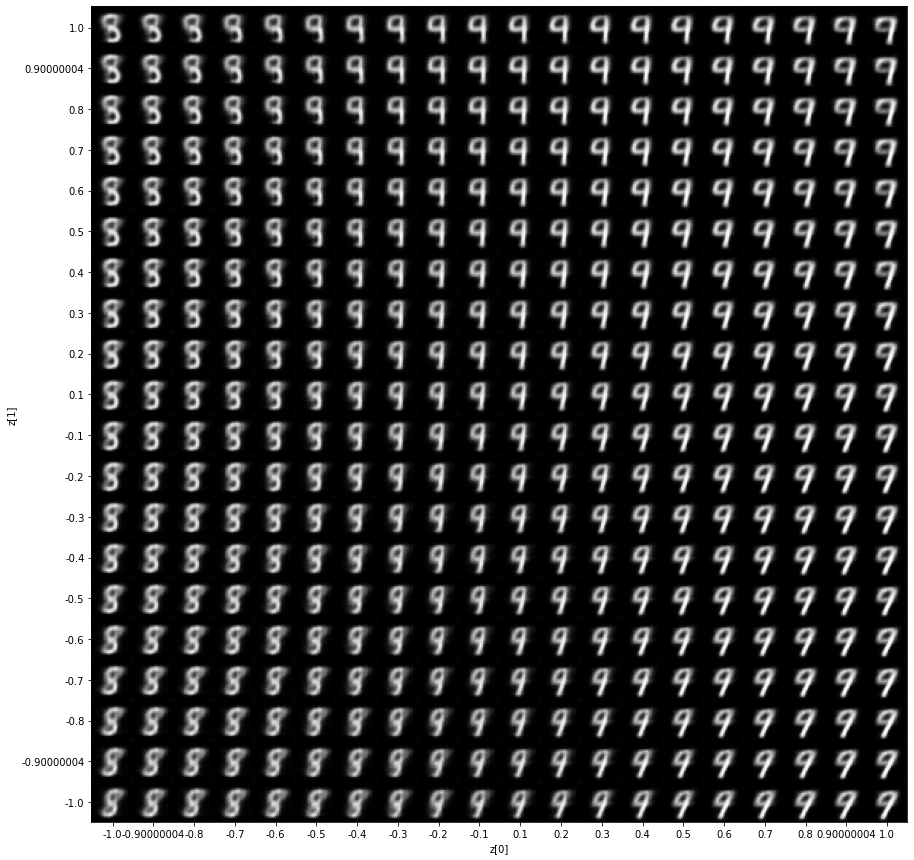

In [43]:
import matplotlib.pyplot as plt
import numpy as np


# display a n*n 2D manifold of digits
n = 20
digit_size = 28
scale = 1.0
figure = np.zeros((digit_size * n, digit_size * n), dtype=jnp.uint8)
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = jnp.linspace(-scale, scale, n)
grid_y = jnp.linspace(-scale, scale, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = jnp.array([[xi, yi]])
        x_decoded = jax.lax.clamp(0., 255 * decoder.apply(params_dec, z_sample), 255.).astype(jnp.uint8)
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = jax.device_get(digit)

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap="Greys_r")
plt.show()
